# Semantic Segmentation for Autonomous Driving using U-Net

Region-specific labeling is a crucial process for self-driving cars. It involves categorizing pixels in the car's view to understand its surroundings perfectly. This pixel-level understanding is essential for safe maneuvers like lane-changing and obstacle avoidance. The car uses advanced computer vision and machine learning, particularly deep learning models like CNNs, to recognize different objects and regions. These models are trained on large datasets with labeled images to accurately classify pixels. The labeled regions help the car's perception system create a detailed representation of the world, enabling real-time decision-making for safe navigation. To adapt to various regions, the labeling process may require adjustments based on local road conditions, traffic rules, and driving habits. Ultimately, region-specific labeling ensures self-driving cars can operate autonomously and securely, protecting lives on the road.

In [73]:
#import libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
import os
import numpy as np
import pandas as pd
import imageio.v2 as imageio
import matplotlib.pyplot as plt
%matplotlib inline
#from test_utils import summary, comparator

In [201]:
current_directory = os.getcwd()
# Print the current directory
#print("Current Directory:", current_directory)
img_path = './images/dataD/dataD/CameraRGB/'
seg_path = './images/dataD/dataD/CameraSeg/'

In [202]:
img_list = os.listdir(img_path) # list of files in the img directory
#print(img_list)
seg_list = os.listdir(seg_path)

In [203]:
# Get the total number of segmented classes

# Initialize an empty list to store unique class labels
unique_classes = set()

# Loop through all segmentation maps and extract unique class labels
for seg_file in seg_list:
    # Load the segmentation map as a numpy array
    seg = imageio.imread(os.path.join(seg_path, seg_file))

    # Extract unique class labels and add them to the set
    unique_classes.update(np.unique(seg))

# Convert the set of unique class labels to a sorted list
unique_classes_list = sorted(list(unique_classes))

# Print the total number of classes
print("Total number of classes in the Carla dataset:", len(unique_classes_list))

Total number of classes in the Carla dataset: 13


In [204]:
# convert each file to a path
img_list = [img_path+i for i in img_list] # set each file with a path
#print(img_list)
seg_list = [seg_path+i for i in seg_list]

In [205]:
print(len(img_list))
print(len(seg_list))

1000
1000


Text(0.5, 1.0, 'Segmented Ground Truth')

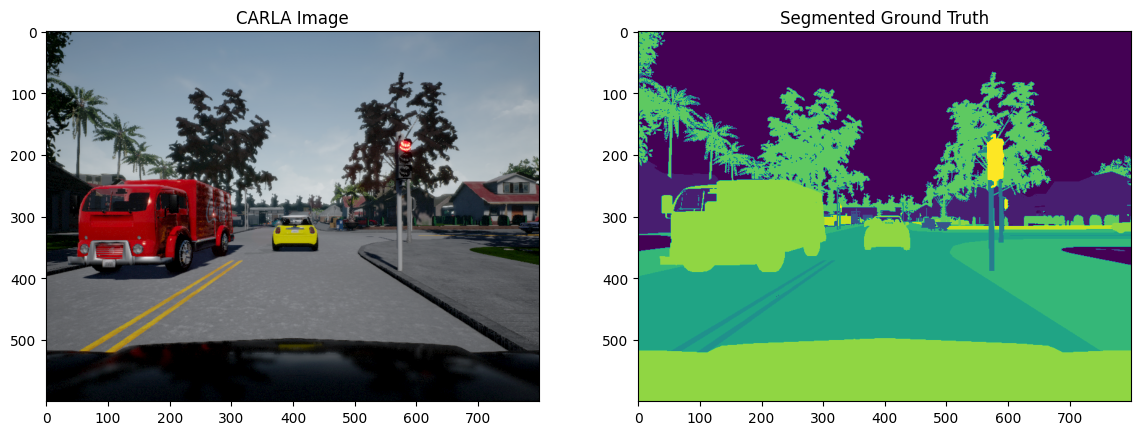

In [206]:
N = 145
img = imageio.imread(img_list[N]) # Returns a numpy array
seg = imageio.imread(seg_list[N])
fig, ax = plt.subplots(1, 2, figsize=(14, 14))
ax[0].imshow(img)
ax[0].set_title('CARLA Image')
ax[1].imshow(seg[:, :, 0]) # extract the first channel of the segmentation map for visualizing, where each pixel's intensity represents 
                           # the class label of that pixel in the original image.
ax[1].set_title('Segmented Ground Truth')

In [207]:
#img_list_ds = tf.data.Dataset.list_files(img_list, shuffle=False)
#seg_list_ds = tf.data.Dataset.list_files(seg_list, shuffle=False)

#for path in zip(image_list_ds.take(3), seg_list_ds.take(3)):
 #   print(path)

In [216]:
img_filenames = tf.constant(img_list) # convert list into a tensor
seg_filenames = tf.constant(seg_list)

print(len(img_filenames))
print(len(seg_filenames))

dataset = tf.data.Dataset.from_tensor_slices((img_filenames, seg_filenames))
#print('dataset', dataset)

#for image, seg in dataset.take(1):
 #   print(image)
  #  print(seg)

1000
1000


<a name='2-2'></a>
### 2.2 - Preprocess Your Data

In [217]:
# Pre-process your data
def path_processing(img_path, seg_path):
    img = tf.io.read_file(img_path) # Reads the contents of file.
    img = tf.image.decode_png(img, channels=3) # convert PNG image data, into a tensor representation
    img = tf.image.convert_image_dtype(img, tf.float32) 
    seg = tf.io.read_file(seg_path)
    seg = tf.image.decode_png(seg, channels=3)
    seg = tf.math.reduce_max(seg, axis=-1, keepdims=True)
    return img, seg

def preprocess(img, seg):
    input_img = tf.image.resize(img, (96, 128), method='nearest')
    input_seg = tf.image.resize(seg, (96, 128), method='nearest')

    input_img = input_img / 255.

    return input_img, input_seg

img_ds = dataset.map(path_processing)
processed_image_ds = img_ds.map(preprocess)

<a name='3'></a>
## 3 - U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

<a name='ex-1'></a>
### Exercise 1 - conv_block

Implement `conv_block(...)`. Here are the instructions for each step in the `conv_block`, or contracting block: 

* Add 2 **Conv2D** layers with `n_filters` filters with `kernel_size` set to 3, `kernel_initializer` set to ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` set to 'same' and 'relu' activation.
* if `dropout_prob` > 0, then add a Dropout layer with parameter `dropout_prob`
* If `max_pooling` is set to True, then add a MaxPooling2D layer with 2x2 pool size

In [33]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(2,strides=2)(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [34]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

#print('Block 1:')
#for layer in summary(model1):
#    print(layer)

#comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
#print('\nBlock 2:')   
#for layer in summary(model2):
#    print(layer)
    
#comparator(summary(model2), output2)

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


<a name='ex-2'></a>
### Exercise 2 - upsampling_block

Implement `upsampling_block(...)`.

For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block you completed previously
* Your `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 

This block is also where you'll concatenate the outputs from the encoder blocks, creating skip connections. 

* Concatenate your Conv2DTranspose layer output to the contractive input, with an `axis` of 3. In general, you can concatenate the tensors in the order that you prefer. But for the grader, it is important that you use `[up, contractive_input]`

For the final component, set the parameters for two Conv2D layers to the same values that you set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 


In [35]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [36]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

#print('Block 1:')
#for layer in summary(model1):
 #   print(layer)

#comparator(summary(model1), output1)

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset. 

<a name='ex-3'></a>
### Exercise 3 - unet_model

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout` of 0.3
* For the final conv_block, set `dropout` to 0.3 again, and turn off max pooling. (Here `n_filters=n_filters* 16`)

For the second half:
* From here, at each step, use half the number of filters of the previous block
* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is your bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer. 
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model. 

In [37]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [38]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
#comparator(summary(unet), outputs.unet_model_output)


<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [39]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [40]:
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 96, 128, 32)          896       ['input_6[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_26[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_27[0][0]']           
 g2D)                                                                                       

In [41]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Seg', 'Predicted Seg']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [54]:
sample_data = list(image_ds.take(1))
print(sample_data)
# Check if the list is not empty (to ensure there is an element in the dataset)
if sample_data:
    # Unpack the tuple containing image and segmentation
    image, seg = sample_data[0]
    # Now you have access to the image and segmentation variables
    # and you can use them as needed.
    print("Image shape:", image.shape)
    print("Segmentation shape:", seg.shape)
else:
    print("Dataset is empty or has less than 1 element.")

[(<tf.Tensor: shape=(600, 800, 3), dtype=float32, numpy=
array([[[0.08627451, 0.08627451, 0.10980393],
        [0.0509804 , 0.0509804 , 0.08627451],
        [0.        , 0.0509804 , 0.0509804 ],
        ...,
        [0.6627451 , 0.67058825, 0.6745098 ],
        [0.6627451 , 0.67058825, 0.6745098 ],
        [0.6431373 , 0.6509804 , 0.65882355]],

       [[0.0509804 , 0.0509804 , 0.08627451],
        [0.0509804 , 0.0509804 , 0.08627451],
        [0.        , 0.        , 0.        ],
        ...,
        [0.6627451 , 0.6745098 , 0.6745098 ],
        [0.65882355, 0.67058825, 0.6745098 ],
        [0.6431373 , 0.6509804 , 0.65882355]],

       [[0.0509804 , 0.0509804 , 0.08627451],
        [0.0509804 , 0.08627451, 0.10980393],
        [0.        , 0.        , 0.        ],
        ...,
        [0.6627451 , 0.6745098 , 0.6745098 ],
        [0.6627451 , 0.6745098 , 0.6745098 ],
        [0.64705884, 0.654902  , 0.65882355]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.

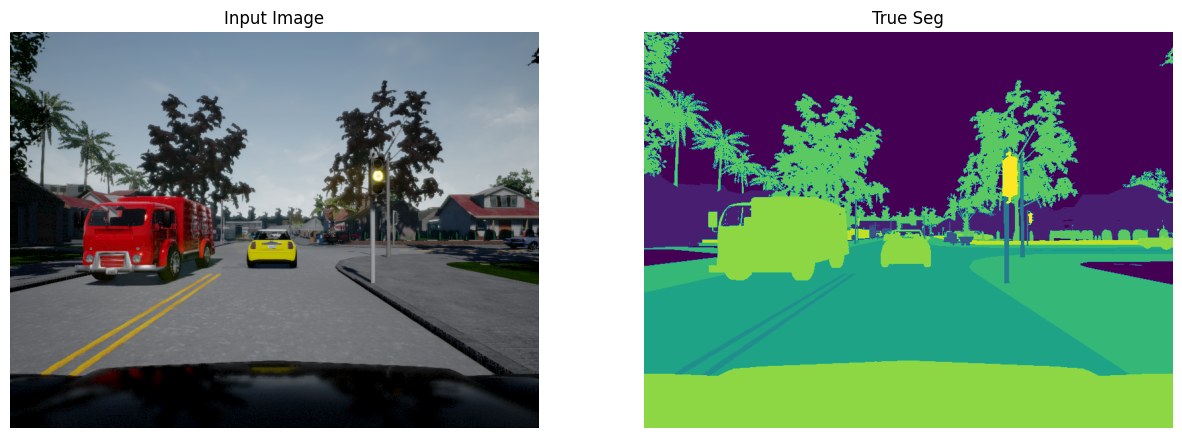

In [58]:
for sample_data in list(image_ds.take(145)):
    sample_image, sample_seg = sample_data
display([sample_image, sample_seg])

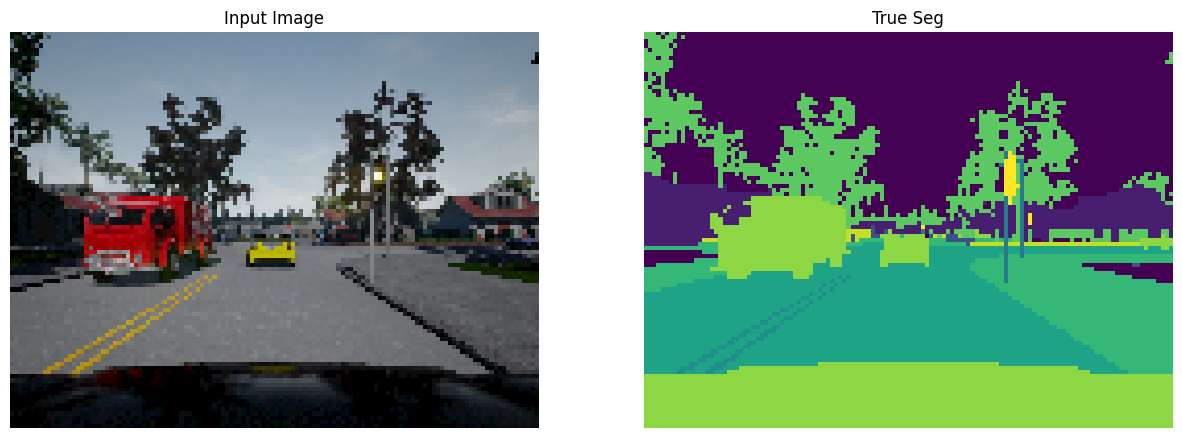

In [59]:
for processed_sample_data in list(processed_image_ds.take(145)):
    sample_processed_image, sample_processed_seg = processed_sample_data
display([sample_processed_image, sample_processed_seg])

<a name='4'></a>
## 4 - Train the Model

In [60]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
32/32 [==============================] - 93s 3s/step - loss: 2.8374 - accuracy: 0.2149
Epoch 2/40
32/32 [==============================] - 87s 3s/step - loss: 1.7905 - accuracy: 0.3302
Epoch 3/40
32/32 [==============================] - 90s 3s/step - loss: 0.9864 - accuracy: 0.6838
Epoch 4/40
32/32 [==============================] - 84s 3s/step - loss: 0.8037 - accuracy: 0.7168
Epoch 5/40
32/32 [==============================] - 84s 3s/step - loss: 0.7054 - accuracy: 0.7492
Epoch 6/40
32/32 [==============================] - 86s 3s/step - loss: 0.6119 - accuracy: 0.7808
Epoch 7/40
32/32 [==============================] - 83s 3s/step - loss: 0.5740 - accuracy: 0.7929
Epoch 8/40
32/32 [==============================] - 84s 3s/step - loss: 0.5591 - accuracy: 0.8016
Epoch 9/40
32/32 [==============================] - 85s 3s/step - loss: 0.5288 - accuracy: 0.82

In [62]:
def create_seg(pred_seg):
    pred_seg = tf.argmax(pred_seg, axis=-1)
    pred_seg = pred_seg[..., tf.newaxis]
    return pred_seg[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

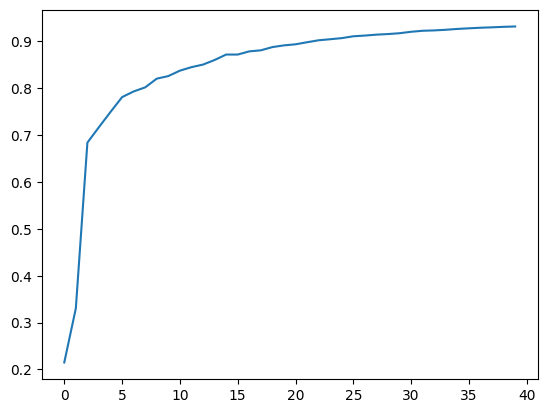

In [63]:
plt.plot(model_history.history["accuracy"])

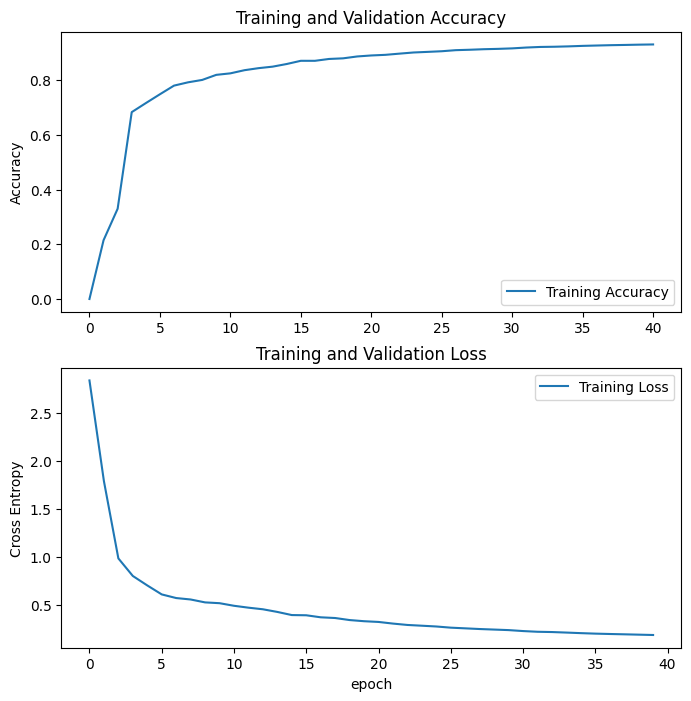

In [72]:
acc = [0.] + model_history.history['accuracy']
#val_acc = [0.] + model_history.history['val_accuracy']

loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, seg in dataset.take(num):
            pred_seg = unet.predict(image)
            display([image[0], seg[0], create_seg(pred_seg)])
    else:
        display([sample_image, sample_seg,
             create_seg(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 841ms/step


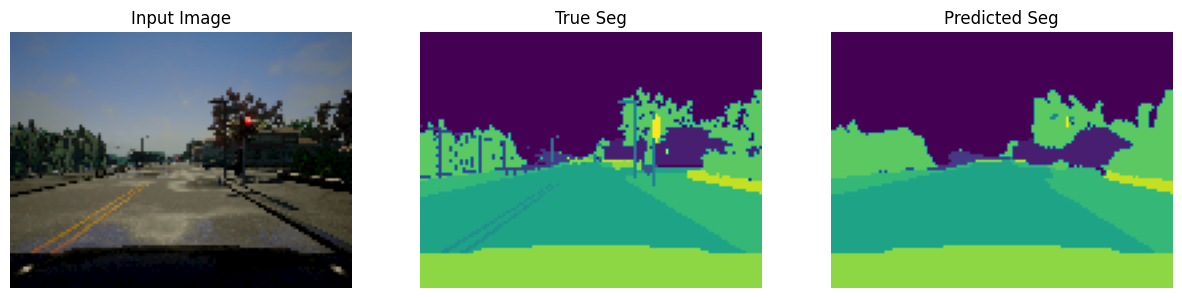

1/1 [==============================] - 1s 591ms/step


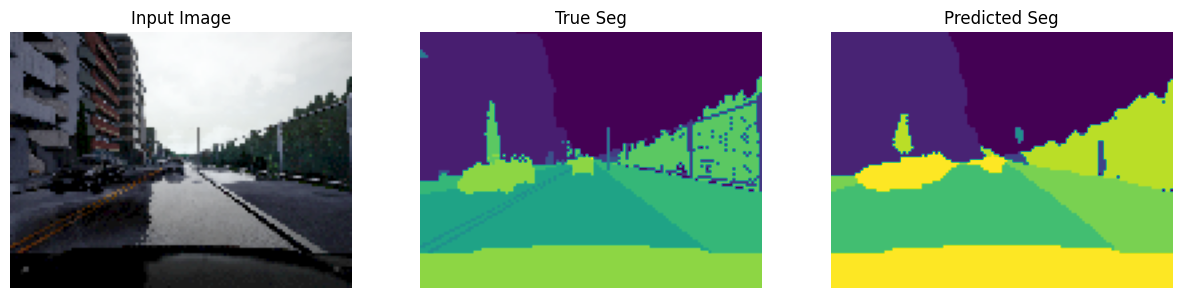

1/1 [==============================] - 1s 548ms/step


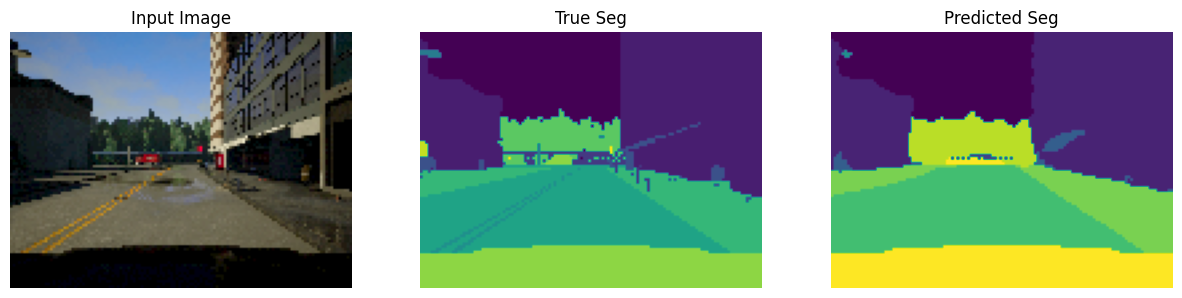

1/1 [==============================] - 1s 541ms/step


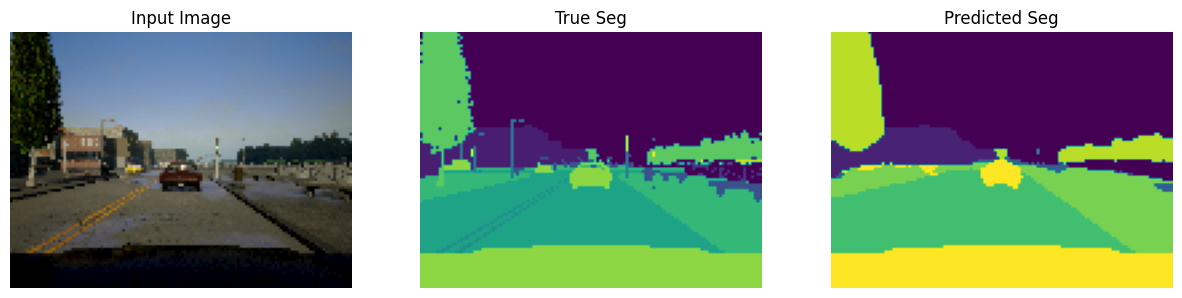

1/1 [==============================] - 1s 558ms/step


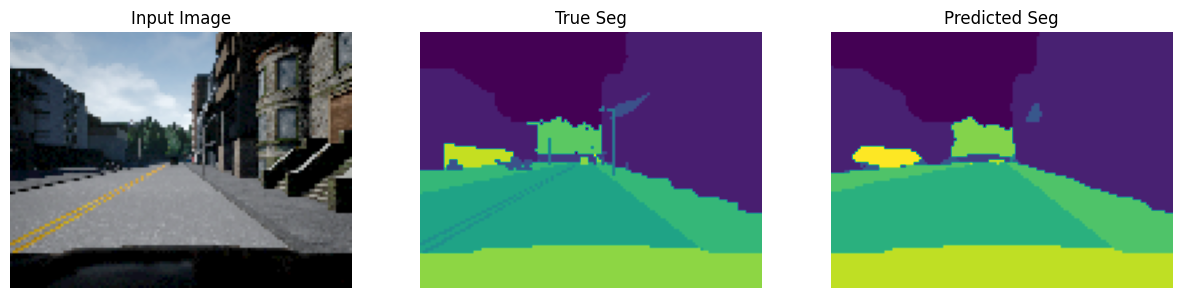

1/1 [==============================] - 1s 560ms/step


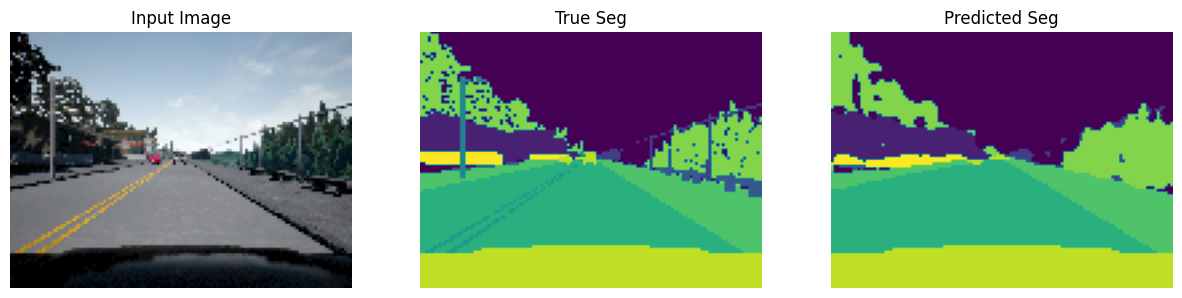

In [65]:
show_predictions(train_dataset, 6)